# PyCWB Tutorial

## 1. Setup

### 1.1 Setup environment and read the user config

In [1]:
import os

import pycwb
from pycwb.config import Config
from pycwb.modules.logger import logger_init

if not os.environ.get('HOME_WAT_FILTERS'):
    pyburst_path = os.path.dirname(os.path.abspath(pycwb.__file__))
    os.environ['HOME_WAT_FILTERS'] = f"{os.path.abspath(pyburst_path)}/vendor"

logger_init()

config = Config('./user_parameters.yaml')
config.ifo, config.injection

Welcome to JupyROOT 6.26/10
Loading wavelet library
Trying to load wavelet library from /usr/local/anaconda3/envs/cwb/lib/python3.10/site-packages/lib/wavelet


23-09-10 23:00:38 - logger_init - INFO - Logging initialized
23-09-10 23:00:38 - logger_init - INFO - Logging level: INFO
23-09-10 23:00:38 - logger_init - INFO - Logging file: None
23-09-10 23:00:39 - check_MRA_catalog - INFO - Checking MRA catalog
23-09-10 23:00:40 - load_MRA - INFO - Loading catalog of WDM cross-talk coefficients: /Users/yumengxu/Project/Physics/cwb/pyBurst/pycwb/vendor/wdmXTalk/OverlapCatalog16-1024.bin


(['L1', 'H1'],
 {'segment': {'start': 1126258862.4,
   'end': 1126260062.4,
   'noise': {'seeds': [0, 1]}},
  'parameters': {'mass1': 20,
   'mass2': 20,
   'spin1z': 0,
   'spin2z': 0,
   'distance': 300,
   'inclination': 0,
   'polarization': 0,
   'gps_time': 1126259462.4,
   'coa_phase': 0,
   'ra': 0,
   'dec': 0},
  'approximant': 'IMRPhenomXHM'})

### 1.2 Create Job Segment from Injection

In [2]:
from pycwb.modules.job_segment import create_job_segment_from_injection

job_segments = create_job_segment_from_injection(config.ifo, config.simulation, config.injection)
job_segments

[WaveSegment(index=0, start_time=1126258862.4, end_time=1126260062.4, frames=0, injections=[{'mass1': 20, 'mass2': 20, 'spin1z': 0, 'spin2z': 0, 'distance': 300, 'inclination': 0, 'polarization': 0, 'gps_time': 1126259462.4, 'coa_phase': 0, 'ra': 0, 'dec': 0}])]

### 1.3 Generate injection data

In [3]:
from pycwb.modules.read_data import generate_injection

data = generate_injection(config, job_segments[0])
data

23-09-10 23:00:49 - generate_injection - INFO - Generating noise for ['L1', 'H1']
23-09-10 23:01:01 - generate_injection - INFO - Generating injection for ['L1', 'H1'] with parameters: 
 {'mass1': 20, 'mass2': 20, 'spin1z': 0, 'spin2z': 0, 'distance': 300, 'inclination': 0, 'polarization': 0, 'gps_time': 1126259462.4, 'coa_phase': 0, 'ra': 0, 'dec': 0, 'approximant': 'IMRPhenomXHM', 'delta_t': 6.103515625e-05, 'f_lower': 16.0} 



Here, you can see the generate_injection function accept one job_segment and return a list of pycbc time series for each detector.

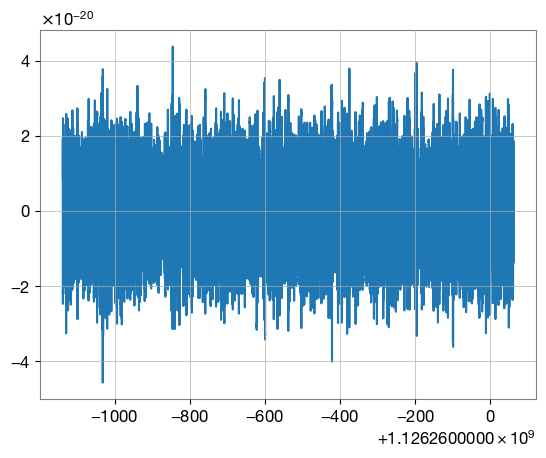

In [4]:
%matplotlib inline
# plot the pycbc time series for L1
data[0].plot()

## 2. Analyze the data

### 2.1 apply data conditioning to the data

23-09-10 23:01:07 - data_conditioning - INFO - Start data conditioning in parallel
23-09-10 23:01:13 - data_conditioning - INFO - -------------------------------------------------------
23-09-10 23:01:13 - data_conditioning - INFO - Data Conditioning Time: 6.34 seconds
23-09-10 23:01:13 - data_conditioning - INFO - -------------------------------------------------------


((<pycwb.types.time_frequency_series.TimeFrequencySeries at 0x7fac5d98ec80>,
  <pycwb.types.time_frequency_series.TimeFrequencySeries at 0x7fac5d98efe0>),
 (<pycwb.types.time_frequency_series.TimeFrequencySeries at 0x7fac5d98ee00>,
  <pycwb.types.time_frequency_series.TimeFrequencySeries at 0x7fac5d98f100>))

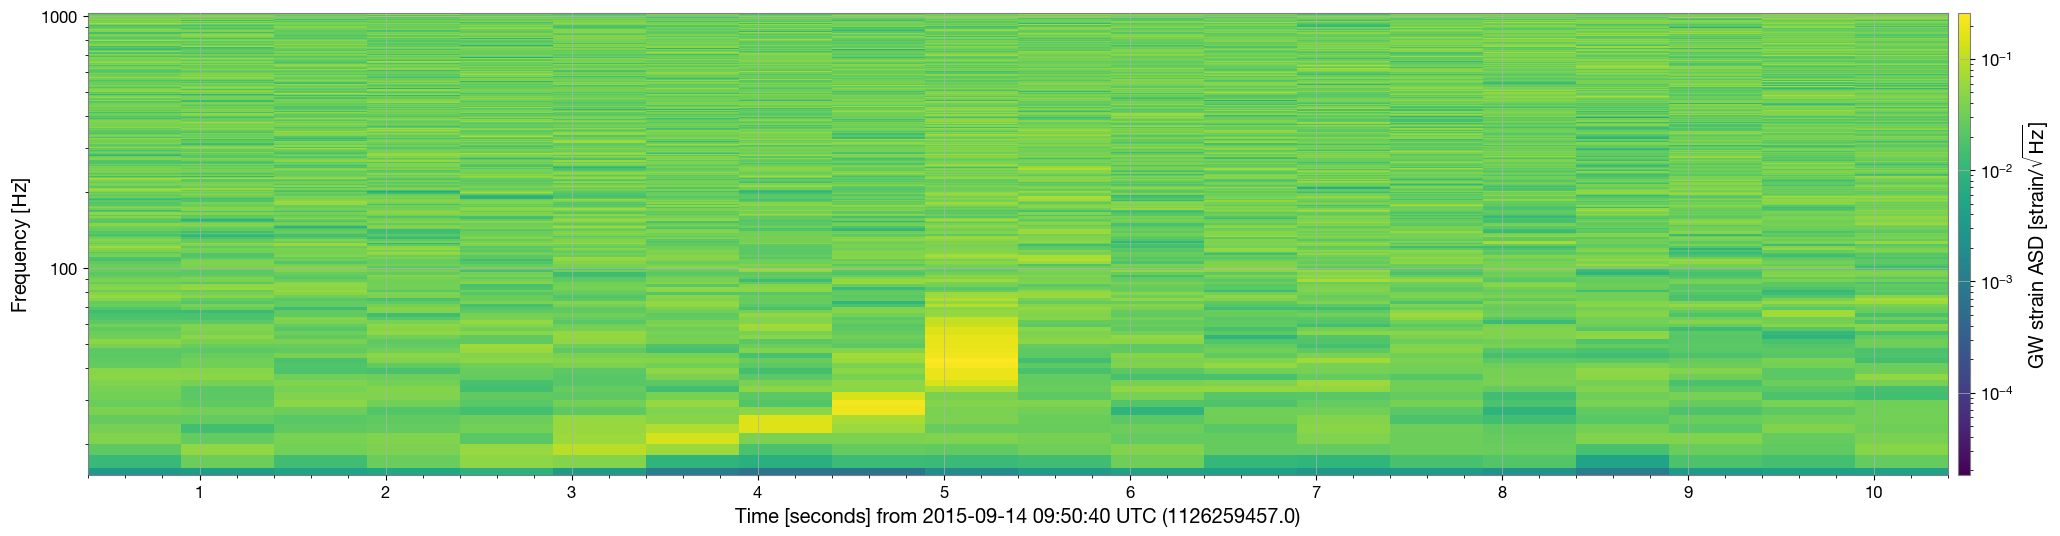

In [5]:
from pycwb.modules.data_conditioning import data_conditioning
from pycwb.modules.plot import plot_spectrogram

strains, nRMS = data_conditioning(config, data)

# plot the spectrogram for L1
injection_time = job_segments[0].injections[0]['gps_time']
plt = plot_spectrogram(strains[0], gwpy_plot=True, xmin=injection_time-5, xmax=injection_time+5)
ax = plt.gca()
ax.set_ylim(15,1024)
strains, nRMS

### 2.2 Find coherent pixels and clusters

In [6]:
from pycwb.modules.coherence import coherence

# calculate coherence
fragment_clusters = coherence(config, strains, nRMS)

23-09-10 23:01:16 - coherence - INFO - Start coherence in parallel
23-09-10 23:01:27 - _coherence_single_res - INFO - level : 8	 rate(hz) : 8	 layers : 256	 df(hz) : 4.000000	 dt(ms) : 125.000000 
max energy in units of noise variance: 1.61958 
thresholds in units of noise variance: Eo=6.79939 Emax=13.5988 
live time in zero lag: 1180 
lag | clusters | pixels 
  0 |        2 |    244 
Coherence time for single level: 10.854976 s
23-09-10 23:01:27 - _coherence_single_res - INFO - level : 9	 rate(hz) : 4	 layers : 512	 df(hz) : 2.000000	 dt(ms) : 250.000000 
max energy in units of noise variance: 1.54846 
thresholds in units of noise variance: Eo=6.74676 Emax=13.4935 
live time in zero lag: 1180 
lag | clusters | pixels 
  0 |        3 |    251 
Coherence time for single level: 10.960099 s
23-09-10 23:01:27 - _coherence_single_res - INFO - level : 6	 rate(hz) : 32	 layers : 64	 df(hz) : 16.000000	 dt(ms) : 31.250000 
max energy in units of noise variance: 2.18598 
thresholds in units of 

### 2.3 supercluster

In [7]:
from pycwb.modules.super_cluster import supercluster
from pycwb.types.network import Network

network = Network(config, strains, nRMS)

pwc_list = supercluster(config, network, fragment_clusters, strains)

23-09-10 23:01:35 - set_time_shift - INFO - lag step: 1.0
23-09-10 23:01:35 - set_time_shift - INFO - number of time lags: 1
23-09-10 23:01:37 - sparse_table_from_fragment_clusters - INFO - ----------------------------------------
23-09-10 23:01:37 - sparse_table_from_fragment_clusters - INFO - Sparse series time: 1.91 s
23-09-10 23:01:37 - sparse_table_from_fragment_clusters - INFO - ----------------------------------------
23-09-10 23:01:39 - supercluster - INFO - -> Processing lag=0 ...
23-09-10 23:01:39 - supercluster - INFO -    --------------------------------------------------
23-09-10 23:01:39 - supercluster - INFO -     coher clusters|pixels      :     17|1363
23-09-10 23:01:39 - supercluster - INFO -     super clusters|pixels      :      1|1345
23-09-10 23:01:39 - supercluster - INFO -    defrag clusters|pixels      :      1|1345
23-09-10 23:01:40 - supercluster - INFO -    subnet clusters|pixels      :      1|1345
23-09-10 23:01:40 - supercluster - INFO - Supercluster done
2

### 2.4 Calculate likelihood

In [8]:
from pycwb.modules.likelihood import likelihood

events, clusters, skymap_statistics = likelihood(config, network, pwc_list)

23-09-10 23:01:41 - likelihood - INFO - -------------------------------------------------------
23-09-10 23:01:41 - likelihood - INFO - -> Processing 1 clusters in lag=0
23-09-10 23:01:41 - likelihood - INFO -    ----------------------------------------------------
23-09-10 23:01:57 - _likelihood - INFO - Selected core pixels: 1
23-09-10 23:01:57 - _likelihood - INFO -    cluster-id|pixels:     1|1345
23-09-10 23:01:57 - _likelihood - INFO - 	 -> SELECTED !!!
23-09-10 23:02:00 - likelihood - INFO - -------------------------------------------------------
23-09-10 23:02:00 - likelihood - INFO - Total events: 1
23-09-10 23:02:00 - likelihood - INFO - Total time: 19.17 s
23-09-10 23:02:00 - likelihood - INFO - -------------------------------------------------------
mchirp_2g : 1 1 1.72e+01 0.323 599.994 0.000 1.310 



## Post-processing

### mark the event on the time-frequency map

/usr/local/anaconda3/envs/cwb/lib/python3.10/site-packages/gwpy/plot/plot.py:287: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super().show(warn=warn)


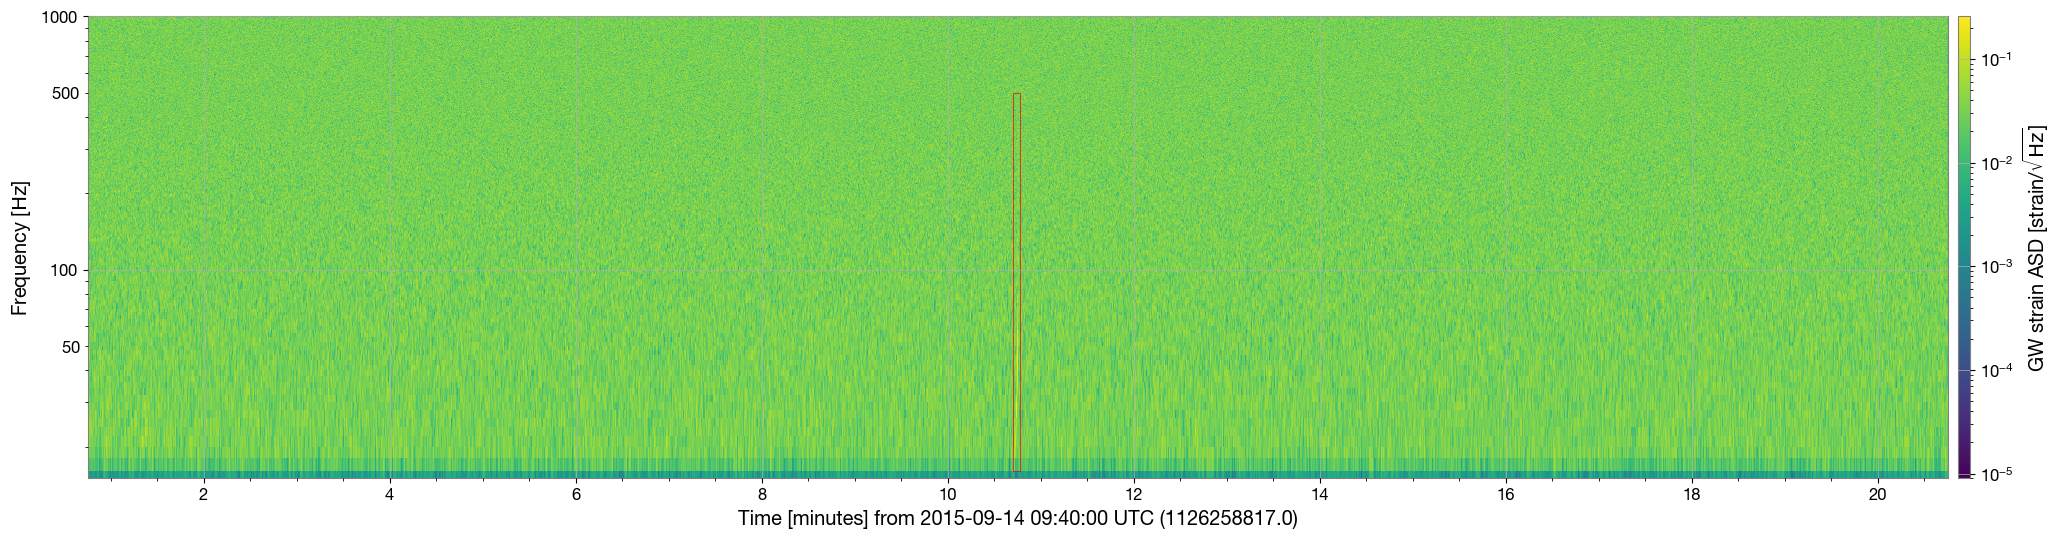

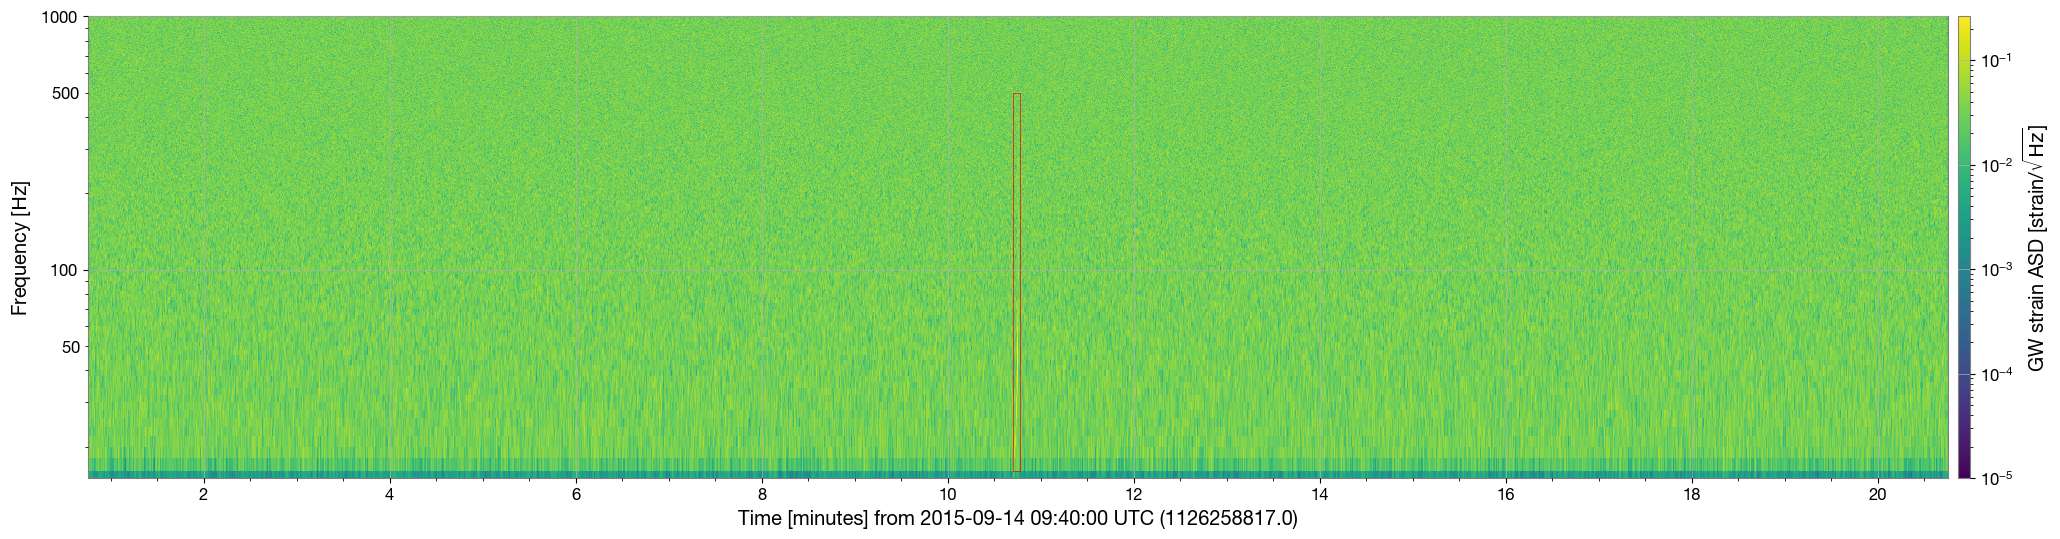

In [9]:
%matplotlib inline
from pycwb.modules.plot import plot_event_on_spectrogram

for i, tf_map in enumerate(strains):
    plt = plot_event_on_spectrogram(tf_map, events)
    plt.show()

### Plot the likelihood of pixels

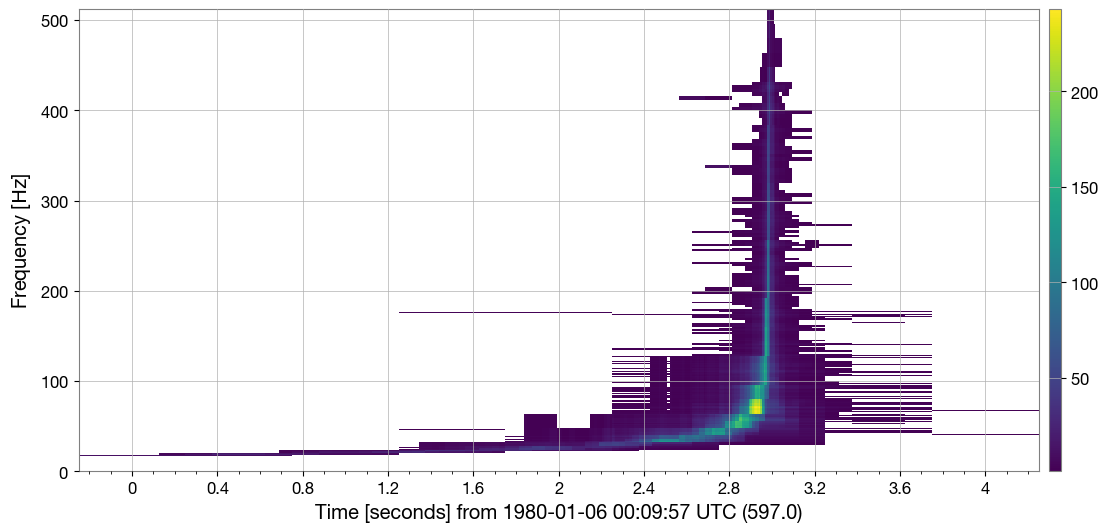

In [10]:
%matplotlib inline
from gwpy.spectrogram import Spectrogram

for cluster in clusters:
    merged_map, start, dt, df = cluster.get_sparse_map("likelihood")

    plt = Spectrogram(merged_map, t0=start, dt=dt, f0=0, df=df).plot()
    plt.colorbar()

### Plot null energy of pixels

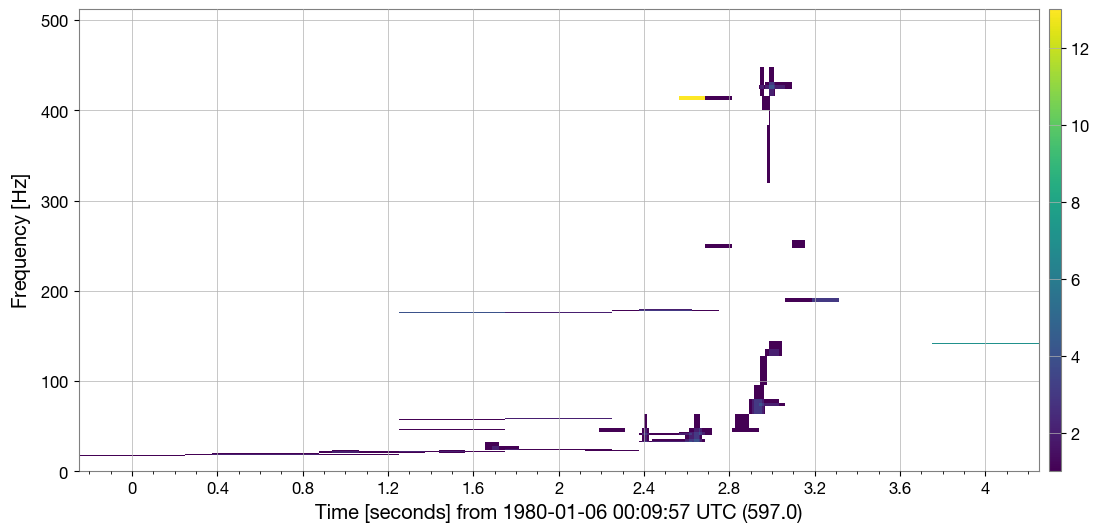

In [11]:
%matplotlib inline
from gwpy.spectrogram import Spectrogram

for cluster in clusters:
    merged_map, start, dt, df = cluster.get_sparse_map("null")

    plt = Spectrogram(merged_map, t0=start, dt=dt, f0=0, df=df).plot()
    plt.colorbar()

### Reconstruct waveform and use autoencoder to calculate glitchness

23-09-10 23:02:49 - _init_num_threads - INFO - Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
23-09-10 23:02:49 - _init_num_threads - INFO - NumExpr defaulting to 8 threads.
init autoencoder
load autoencoder weights =  /Users/yumengxu/Project/Physics/cwb/pyBurst/pycwb/vendor/autoencoder/cwb_autoencoder.h5
glitchness: 0.007810614534461883


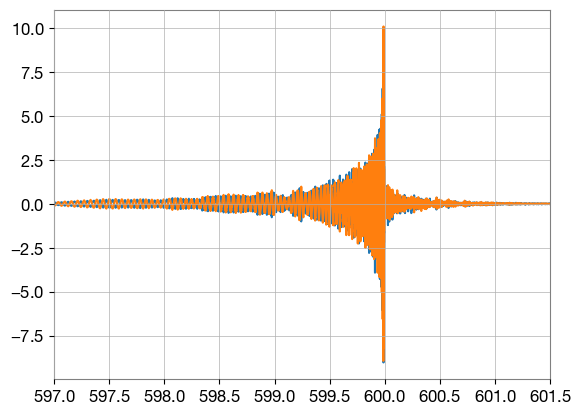

In [12]:
from pycwb.modules.reconstruction import get_network_MRA_wave
from matplotlib import pyplot as plt
from pycwb.modules.autoencoder import get_glitchness

cluster = clusters[0]
event = events[0]

# reconstruct the wave
reconstructed_waves = get_network_MRA_wave(config, cluster, config.rateANA, config.nIFO, config.TDRate,
                                           'signal', 0, True)
# plot the reconstructed wave
for j, reconstructed_wave in enumerate(reconstructed_waves):
    plt.plot(reconstructed_wave.sample_times, reconstructed_wave.data)
    plt.xlim(event.left[0], event.left[0] + event.stop[0] - event.start[0])

glitchness = get_glitchness(config, reconstructed_waves, events[0].sSNR, events[0].likelihood)
print(f"glitchness: {glitchness[0][0]}")

### plot sky statistics

<module 'matplotlib.pyplot' from '/usr/local/anaconda3/envs/cwb/lib/python3.10/site-packages/matplotlib/pyplot.py'>

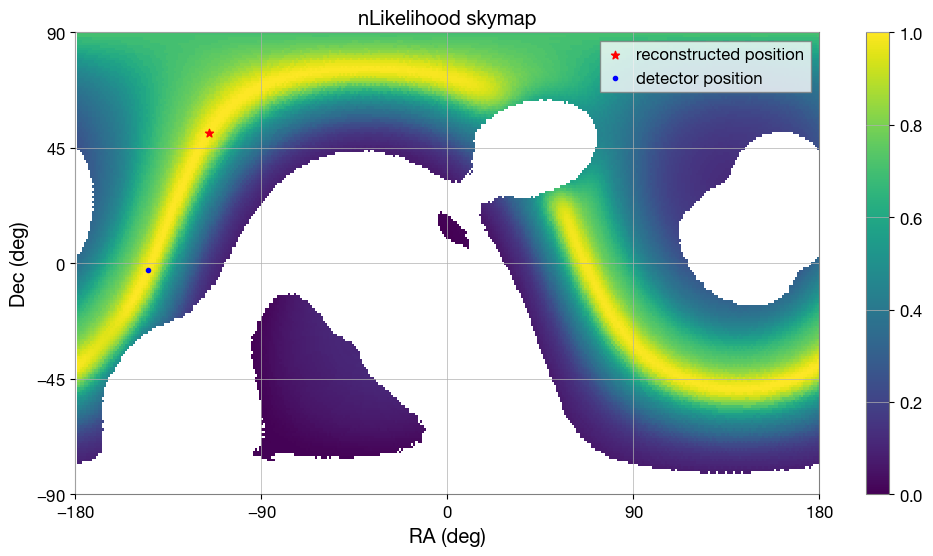

In [13]:
from pycwb.modules.plot_map.world_map import plot_skymap_contour

event = events[0]
plot_skymap_contour(skymap_statistics[0],
                    key='nLikelihood',
                    reconstructed_loc=(event.phi[0], event.theta[0]),
                    detector_loc=(event.phi[3], event.theta[3]),
                    resolution=1)